## DCGAN tensorflow tutorial

 - [Collections of GAN implementations](https://github.com/eriklindernoren/PyTorch-GAN)
 - [DCGAN](https://naokishibuya.medium.com/having-fun-with-deep-convolutional-gans-f4f8393686ed)
    - [example](https://github.com/naokishibuya/deep-learning/blob/master/python/dcgan_mnist.ipynb)
 
 
### DCGAN
-  Deep Convolutional Generative Adversarial Networks
-  The generator of the DCGAN uses the transposed convolution technique to perform up-sampling of 2D image size.


### Create Tensorflow environment with venv
- `python3 -m venv --system-site-packages ./venv`
- `source ./venv/bin/activate`
- `pip install --upgrade pip`
- `pip list`
- `deactivate`
- `pip install --upgrade tensorflow`
- `python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"`
 

 ### Create Tensorflow environment with conda
 - [How to use conda](https://www.machinelearningplus.com/deployment/conda-create-environment-and-everything-you-need-to-know-to-manage-conda-virtual-environment/)


 - Create environment
     - `conda create --name {env_name} python=={version}`
     - `conda create --name {env_name} python=={version} {package names}`
     - `conda create --name torch-demo python==3.7.5 numpy pandas matplotlib keras tensorflow scikit-learn`
 - Activate environment
     - `conda activate {env_name}`
 - Deactivate environment
     - `conda deactivate {env_name}`
 - Install packages
     - `conda install {package_name}==1.x.y {package_name}==1.x.y {package_name}==1.x.y ...`
     - `conda install -n tensorflow-keras ipykernel --update-deps --force-reinstall`
 - List packages
     - `conda list`
     - `conda list -n {env_name}`
 - List envs
     - `conda env list`
     - `conda info --envs`
 - Remove envs
     - `conda env remove -n {env_name}`

#### GAN
For each batch (ex. 1 sample image and 1 fake image),
1. set discriminator to be trainable
2. real sample image -> discriminator -> label
3. fake image (latent sample (fake image created from random array) -> generator) -> discriminator -> label
4. set discriminator to be untrainable
5. train gan (latent sample -> generator -> discriminator -> label 1)


### Deep Convolutional GAN (DCGAN) with MNIST
This is a follow-up on [gan_mnist.ipynb](https://github.com/naokishibuya/deep-learning/blob/7760cd36c2b6ea844fd2170e4d874b6c299f4ca3/python/gan_mnist.ipynb). It uses deep convolutional networks in the generator and the discriminator.

In [4]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

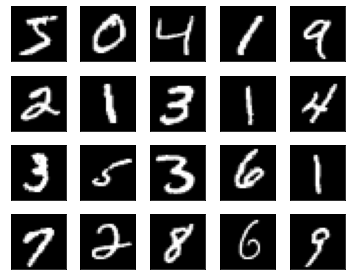

In [6]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Preprocessing and Deprocessing
As usual, we need preprocessing and later deprocessing of the images.

As we will see later on, the generator is using tanh activation, for which we need to preprocess the image data into the range between -1 and 1.

In [8]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [9]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

### Generator

In [17]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

### Discriminator

In [18]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

### DCGAN

In [19]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

### Training DCGAN

In [20]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()  

def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

The training DCGAN is essentially the same as training a simple GAN in gan_mnist.ipynb.

- set the discriminator trainable
- train the discriminator with real images with the label smoothing (labels=1-smooth)
- train the discriminator with fake images generated by the generator (labels=0)
- set the discriminator non-trainable
- train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [21]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

In [ ]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

### Simple GAN example

In [23]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [24]:
make_latent_samples(1, 100) # generates one sample

array([[-1.78048435, -0.14709328,  2.16696008, -0.15305444,  0.57378823,
         2.01797787,  1.18005694,  1.53068339, -0.4853892 ,  0.91392328,
         2.67007149, -0.3074132 ,  0.02754474,  1.17921013, -0.74060151,
        -0.93086508,  0.00945311,  1.12780943,  0.72337511, -1.6466562 ,
        -0.35470572, -1.23292778, -0.72395696, -0.65314903, -0.88359061,
        -0.52383252, -0.91975268, -0.8553815 ,  0.98971831, -1.86296496,
         2.36461153,  0.65383374,  0.99554609, -0.54060251, -0.45213354,
         1.24074467, -0.24055673,  0.02066585,  0.04458491,  0.34599958,
        -0.35180091,  0.01804892,  0.33993063,  0.36261903, -0.44278007,
         0.03267004,  0.79767055,  0.35260536, -0.1088836 ,  0.12835713,
         0.09842776,  1.65307668, -1.07082578,  0.84520285,  0.45281994,
        -1.36023205,  1.98304686, -0.69547427, -0.20035043, -0.05028575,
        -1.61826314,  0.77400082,  1.66643327, -0.43171502, -0.18867593,
         0.36953509, -0.54329648,  0.38336888,  0.4

In [25]:
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.01),
    Dense(784),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [26]:
discriminator = Sequential([
    Dense(128, input_shape=(784,)),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [27]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 214,673
Non-trainable params: 0
_________________________________________________________________


In [28]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [29]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [30]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [31]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [32]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

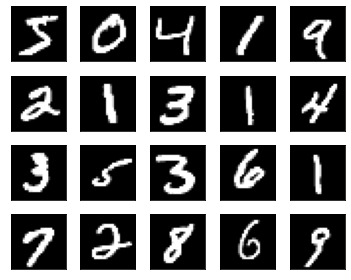

In [34]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [35]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [36]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [37]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))  

Epoch:   1/100 Discriminator Loss: 0.1678 Generator Loss: 2.4330
Epoch:   2/100 Discriminator Loss: 0.2399 Generator Loss: 1.9058
Epoch:   3/100 Discriminator Loss: 0.0835 Generator Loss: 3.1610
Epoch:   4/100 Discriminator Loss: 0.2415 Generator Loss: 2.7680
Epoch:   5/100 Discriminator Loss: 0.6241 Generator Loss: 4.1971
Epoch:   6/100 Discriminator Loss: 0.4516 Generator Loss: 3.8810
Epoch:   7/100 Discriminator Loss: 0.3142 Generator Loss: 1.6592
Epoch:   8/100 Discriminator Loss: 0.2344 Generator Loss: 4.1572
Epoch:   9/100 Discriminator Loss: 0.2266 Generator Loss: 2.8271
Epoch:  10/100 Discriminator Loss: 0.2525 Generator Loss: 2.7030
Epoch:  11/100 Discriminator Loss: 0.2139 Generator Loss: 3.5487
Epoch:  12/100 Discriminator Loss: 0.2795 Generator Loss: 3.2799
Epoch:  13/100 Discriminator Loss: 0.5192 Generator Loss: 1.9267
Epoch:  14/100 Discriminator Loss: 0.3616 Generator Loss: 4.1397
Epoch:  15/100 Discriminator Loss: 0.2978 Generator Loss: 2.3084
Epoch:  16/100 Discrimina

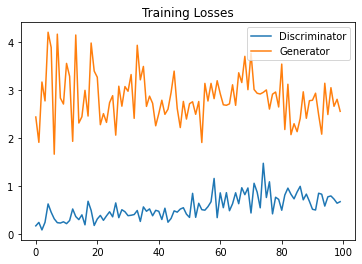

In [38]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

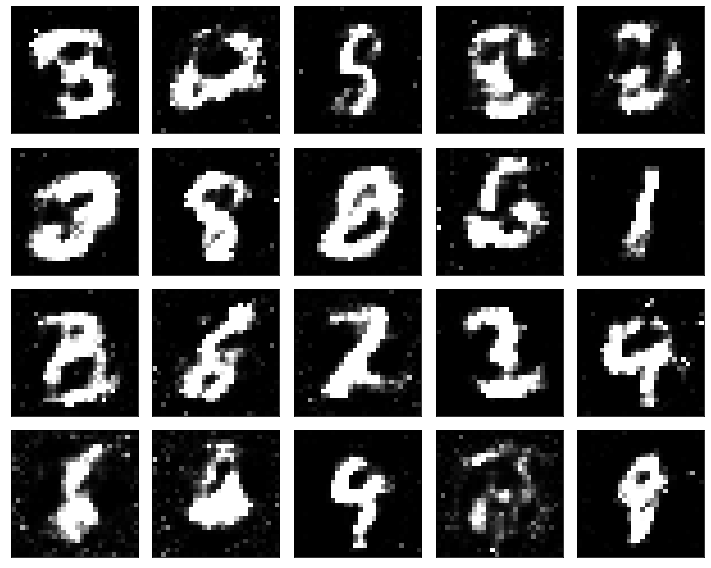

In [39]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()